# Titanic project

The purpose of this project is to perfom some statistical analysis using python about the [Titanic data set](https://www.kaggle.com/c/titanic/data) found on kaggle and draw some initial inferences about the characteristics of the passengers and their probability of survival based on these characterisitcs. Furthermore, a ML model will be trained with the most important features to predict the survival outcome of the passengers.

### Importing the data

We have previously downloaded the data from the link shown above and saved it with the name ['train.csv'](/dataset/train.csv). 

We use pandas csv data reader to import the information into a pandas dataframe and perform a general description of it.

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Importing data
df = pd.read_csv('datasets/train.csv')
print(df.dtypes)
df.head()

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


From the inital description of the data we can see that we have 891 datapoints at our disposal, and 12 attributes:
- A unique passenger ID, stored as an integer
- A binary variable indicating if the passenger survived the sinking (This is the ultimate variable we will try to predict)
- The class of the ticker of the passenger, stored as an integer (i.e 1: First class, 2: Second class...)
- The name of the passenger stored as a string
- The sex of the passenger stored as a string
- The number of sieblings or spouses that the passenger had on board, stored as an integer
- The age of the passenger stored as a float
- The number of parents or children the passenger had on board, stored as a integer
- The ticket number
- The price of the ticker stored as a float
- The cabin number
- The port of embarcation


### Data cleaning

#### Column names
Formatting column titles. We eliminate any space before or after the text on the columns title, and convert them into lowercase

In [3]:
df.columns = [x.strip().lower() for x in df.columns]

#### Missing values
Firstly, we have to make sure there are no missing values in our dataset and if so dealing with them accordingly.

In [4]:
def missing_values(df):
    columns_missin = []
    for column in df.columns:
        if df[column].isnull().values.any():
            missing_pct = df[column].isnull().sum() / 891
            print('Column %s contains %d%% of missing values' %(column, missing_pct*100) )
            columns_missin.append(column)
        else:
            print('Column', column, 'contains NO missing values')

missing_values(df)


Column passengerid contains NO missing values
Column survived contains NO missing values
Column pclass contains NO missing values
Column name contains NO missing values
Column sex contains NO missing values
Column age contains 19% of missing values
Column sibsp contains NO missing values
Column parch contains NO missing values
Column ticket contains NO missing values
Column fare contains NO missing values
Column cabin contains 77% of missing values
Column embarked contains 0% of missing values


Now we know that three of the columns contains some missing values:
- Age contains 19% of the observations with missing values, we can do something to correct them
- Cabin contains 77% of the values missing, so this column was dropped from the rest as well as embarked as it won't be used

We will replace missing values of the age attribute according to the sex. That is, all male missing values will be replaced with the average age of all men, and the same will be applied for females.

In [5]:
df[['sex', 'age']][df['sex'] == 'male']
# Obtaining average ages
avg_male_age = df['age'][df['sex'] == 'male'].mean()
avg_female_age = df['age'][df['sex'] == 'female'].mean()

# Creating a column with the average age of the sex of each passenger
df['age_avgs'] = df.apply(lambda x: avg_male_age if x['sex'] == 'male' 
                                                else avg_female_age, axis=1)

# Filling missing values with the average of the sex of each passenger
df['age'] = df.apply(lambda x: x['age_avgs'] if pd.isnull(x['age']) else x['age'], axis=1)

# Dropping unneccesary columns
df.drop(columns=['age_avgs', 'cabin', 'embarked', 'ticket'], inplace=True)

df.head(6)


,passengerid,survived,pclass,name,sex,age,sibsp,parch,fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.1000
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.0500
5,6,0,3,"Moran, Mr. James",male,30.726645,0,0,8.4583


#### Converting attributes to numeric values
To be able to quantify, we need to convert some of the attributes that are text into a numeric representation of the data. In this case the only attribute of interest remaining to convert is "sex". 

We will define female = 1 and male = 0

In [6]:
df['sex'].replace('male', 0, inplace=True)
df['sex'].replace('female', 1, inplace=True)

df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,fare
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500


#### Extracting information from name
The raw data contains the attribute of name, which is composed by last name, title. First name Second Name. In order to extract the most information out of this attribute we will decompose it into its' individual parts and create new attributes:
- First name
- Middle name
- Last name
- Title

To do this we have to eliminate the parenthesis but not the content between it and then split the text into the components mentioned

In [7]:
def extract_names(df):
    # Deleting the () symbols from name
    df['name'].replace('\(', "", regex=True, inplace=True)
    df['name'].replace('\)', "", regex=True, inplace=True)

    # Extracting attributes
    df['first_name'] = df['name'].apply(lambda x: x.split(',')[1].split('.')[1].split()[0])
    df['middle_name'] = df['name'].apply(lambda x: ' '.join(x.split(',')[1].split('.')[1].split()[1:]))
    df['last_name'] = df['name'].apply(lambda x: x.split(',')[0])
    df['title'] = df['name'].apply(lambda x: x.split(',')[1].split('.')[0])

    return df

extract_names(df)

df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,fare,first_name,middle_name,last_name,title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,Owen,Harris,Braund,Mr
1,2,1,1,"Cumings, Mrs. John Bradley Florence Briggs Thayer",1,38.0,1,0,71.2833,John,Bradley Florence Briggs Thayer,Cumings,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,Laina,,Heikkinen,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath Lily May Peel",1,35.0,1,0,53.1000,Jacques,Heath Lily May Peel,Futrelle,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,William,Henry,Allen,Mr


### Exploratory data analysis

For this section we will take a general look of the variables we have at our disposal, to asess how relevant they can be for the model

#### Distribution of survival attribute
From the figures below, we can see that the survival rate is of only 38.39%, meaning that most of the passenger could not survive the accident.

During the Titanic sinking, the strategy was to board women and children first in the lifeboats.

From the first graph, we can conclude that, of the passengers who survived, most of them were women, and on the other hand, most of the non-survivers were men. 

From the second graph, it is easy to see the distribution of non-survivers with a clear skew towards to lowest classes, with 3rd class having more than 3 times the causalities that those of 1st and second class. 


Survived: 38.383838% 
Did not survive: 61.616162%


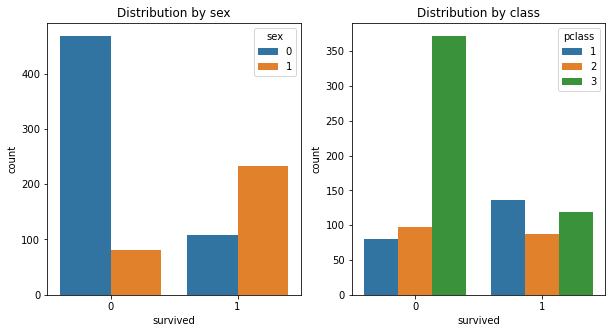

In [40]:
# Obtaining rate of survival
counts = df['survived'].value_counts()
not_survived, survived = counts
print('Survived: %f%% \nDid not survive: %f%%' %(survived*100/len(df['survived']), not_survived*100/len(df['survived'])))

fig, ax = plt.subplots(1,2, figsize=(10,5))

fig.set_facecolor('white') 

ax[0].set_title('Distribution by sex')

sns.countplot(x='survived', hue='sex', data=df, ax = ax[0])
ax[1].set_title('Distribution by class')
sns.countplot(x='survived', hue='pclass', data=df, ax = ax[1])

plt.savefig('graphs/survival.png')



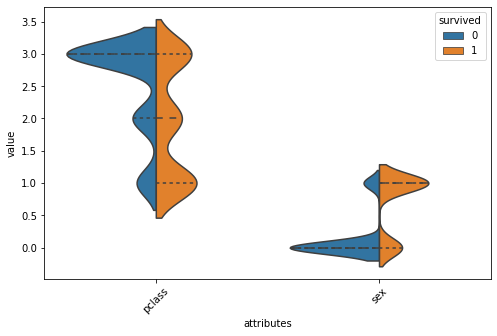

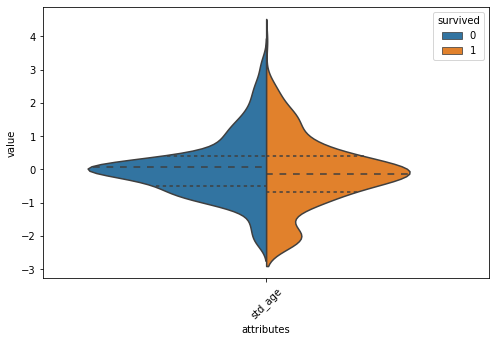

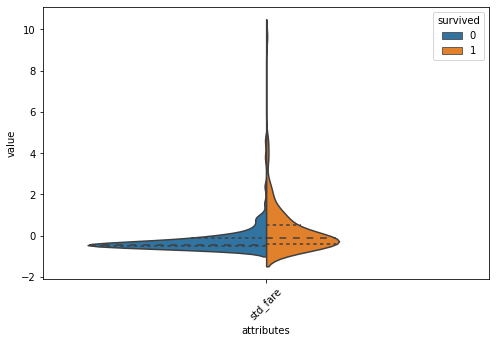

In [41]:
# Function to get the violinplot distribution for any variable
def violin_plot(df, attributes):
    data = df[attributes]
    data = pd.melt(data, id_vars='survived',
                    var_name='attributes',
                    value_name='value',
                    ignore_index=False)

    plt.figure(figsize=(8,5)).set_facecolor('white')
    sns.violinplot(x='attributes', y='value', hue='survived', data=data, split=True, inner='quart')
    plt.xticks(rotation=45)

# Class and sex
attributes = ['survived', 'pclass', 'sex']
violin_plot(df, attributes)
plt.savefig('graphs/violin1.png')
# Age
df['std_age'] = (df['age'] - df['age'].mean())/(df['age'].std())
attributes = ['survived', 'std_age']
violin_plot(df, attributes)
plt.savefig('graphs/violin2.png')
# Fare (needs standarization)
df['std_fare'] = (df['fare'] - df['fare'].mean())/(df['fare'].std())
attributes = ['survived', 'std_fare']
violin_plot(df, attributes)
plt.savefig('graphs/violin3.png')

In [10]:
df['fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64

### Analysis of other variables

#### Title
Below is presented the distribution of titles as well as the survival rate by title. Most of the passengers possesed a title of Mr. with over 500 passengers, followed by Miss and Mrs. with around 200 and 100 respectively. 

As expected from the information obtained in the previous section, titles associated with women had the highest survival rate while titles associated with men had a lower one.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, ' Mr'),
  Text(1, 0, ' Mrs'),
  Text(2, 0, ' Miss'),
  Text(3, 0, ' Master'),
  Text(4, 0, ' Don'),
  Text(5, 0, ' Rev'),
  Text(6, 0, ' Dr'),
  Text(7, 0, ' Mme'),
  Text(8, 0, ' Ms'),
  Text(9, 0, ' Major'),
  Text(10, 0, ' Lady'),
  Text(11, 0, ' Sir'),
  Text(12, 0, ' Mlle'),
  Text(13, 0, ' Col'),
  Text(14, 0, ' Capt'),
  Text(15, 0, ' the Countess'),
  Text(16, 0, ' Jonkheer')])

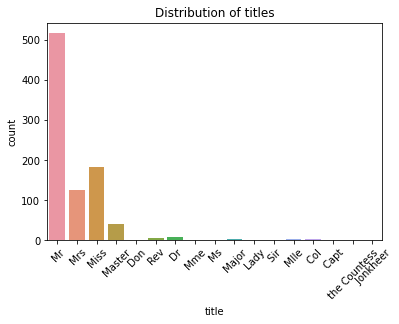

In [11]:
sns.countplot(x='title', data=df)
plt.title('Distribution of titles')
plt.xticks(rotation=45)

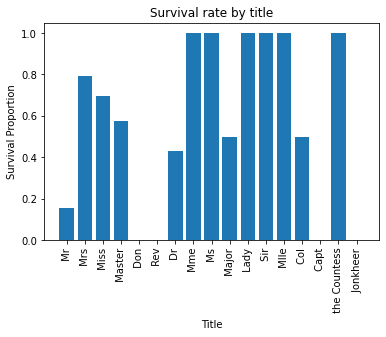

In [42]:
titles = df['title'].unique()

proportions = []

for title in titles: 
    mask = df['title'] == title
    total_title = len(df[mask])
    title_proportion = df[mask]['survived'].sum() / total_title
    proportions.append(title_proportion)

plt.figure().set_facecolor('white')
plt.bar(titles, proportions)
plt.title('Survival rate by title')
plt.xlabel('Title')
plt.xticks(rotation=90)
plt.ylabel('Survival Proportion')
plt.savefig('graphs/survival_rates.png')

plt.show()


#### Converting title attribute to numeric

In [13]:
titles = df['title'].unique()
df['title_num'] = df['title']
numeric_key = 0
for title in titles:
    df['title_num'].replace(title, numeric_key, inplace=True)
    numeric_key = numeric_key + 1
df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,fare,first_name,middle_name,last_name,title,std_age,std_fare,title_num
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,Owen,Harris,Braund,Mr,-0.594398,-0.502163,0
1,2,1,1,"Cumings, Mrs. John Bradley Florence Briggs Thayer",1,38.0,1,0,71.2833,John,Bradley Florence Briggs Thayer,Cumings,Mrs,0.634962,0.786404,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,Laina,,Heikkinen,Miss,-0.287058,-0.488580,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath Lily May Peel",1,35.0,1,0,53.1000,Jacques,Heath Lily May Peel,Futrelle,Mrs,0.404457,0.420494,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,William,Henry,Allen,Mr,0.404457,-0.486064,0


### Decision tree

We are going to use a decision tree model to predict the outcome of a passenger based on his or her attributes. To do so we separate our initial data into a training set, containing 80% of the original data, and a testing set, containing the remaining 20%. For our iniital model we set a random state = 0 and a maximium depth of the 3 of three. This parameters will be tuned. 

This initial model obtained an overall 78.7% accuracy. Given the skew shown above to people not surving, the model has a better accuracy predicting a non-surviver, with an accuracy of 80%, and has a decent accuracy predicting survivors of 77%. 

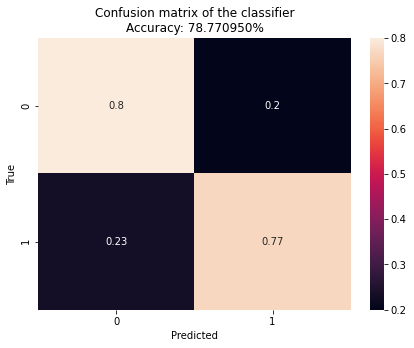

In [43]:
# Importing libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Defining vectors previously extracted
X = df[['pclass', 'sex', 'std_age', 'sibsp', 'parch', 'std_fare', 'title_num']]
y = df['survived']

# Split training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Tree creation
tree_model = tree.DecisionTreeClassifier(random_state=0, max_depth=3)

tree_fit = tree_model.fit(X_train, Y_train)

Y_test_predictions = tree_model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_test_predictions)*100


# Generate confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
#cm= np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
fig, ax = plt.subplots(1,1, figsize=(7,5))
fig.set_facecolor('white')
ax = sns.heatmap(cm, annot=True).set_facecolor('grey')
plt.title('Confusion matrix of the classifier\nAccuracy: %f%%' %(accuracy))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('graphs/initial_matrix.png')
plt.show()


#### Creating a function for the model

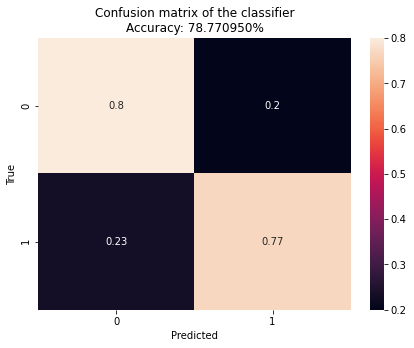

78.77094972067039

In [44]:
# Tree model function
def create_tree(attributes, df, maxdepth = 3, matrix = True, train_pct=0.8):
    # Defining vectors previously extracted
    X = df[attributes]
    y = df['survived']

    # Split training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=train_pct, random_state=0)

    # Tree creation
    tree_model = tree.DecisionTreeClassifier(random_state=0, max_depth=maxdepth)

    tree_fit = tree_model.fit(X_train, Y_train)

    Y_test_predictions = tree_model.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_test_predictions)*100


    if matrix == True:
        # Generate confusion matrix
        cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
        #cm= np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
        fig, ax = plt.subplots(1,1, figsize=(7,5))
        fig.set_facecolor('white')
        ax = sns.heatmap(cm, annot=True).set_facecolor('lightgrey')
        plt.title('Confusion matrix of the classifier\nAccuracy: %f%%' %(accuracy))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    return accuracy

attributes = ['pclass', 'sex', 'std_age', 'sibsp', 'parch', 'std_fare', 'title_num']
create_tree(attributes, df)

### Tuning parameters

#### Checking for correlation
Below, the correlation matrix is shown. We have a couple of variables that present the higuer correlations:
1.- Class and fare: naturally classes are directly related to the price passengers paid
2.- Number of parent and children and number of children and spouse (41%): Potentially wealthier families bring more of their family. 
3.- Sex and title (36%): It makes sense that most most titles are attached to the sex of the passenger. 

Howerver, none of this correlations seem strong enough to be producing a multicollinearity bias problem.

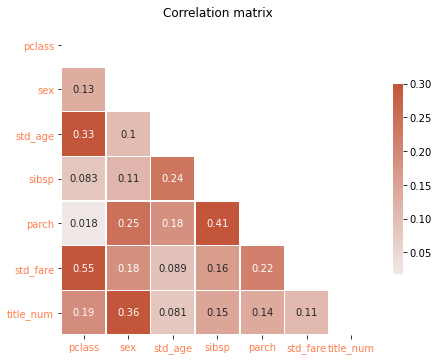

In [24]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(X.corr(), dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))
plt.title('Correlation matrix')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(X.corr().abs(), mask=mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.yticks(rotation=0, color='coral')
plt.xticks(color='coral')
plt.savefig('graphs/corr.png')

#### Optimizing depth of the tree

The plot below shows the evolution of the overall accuracy of the model whith different depths. We reach an overall maximium when the depth is equal to 5 with an accuracy of 82.1%. 

In the long run, it seems to converge to an accuracy of around 77% as depth increases. 

Max accuracy of 82.122905% with depth 5


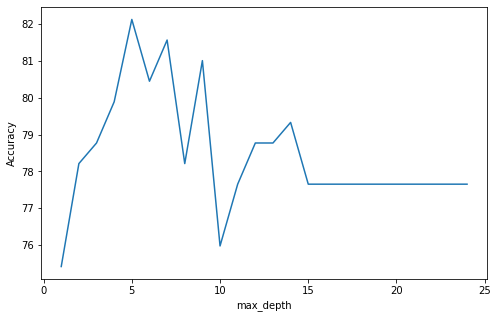

In [45]:
attributes = ['pclass', 'sex', 'std_age', 'sibsp', 'parch', 'std_fare', 'title_num']
tune_accuracies = []
for d in range(1,25):
    tune_accuracies.append(create_tree(attributes, df, maxdepth=d, matrix=False))

fig, ax = plt.subplots(figsize=(8,5))  
ax = plt.plot(list(range(1,25)), tune_accuracies)
fig.set_facecolor('white')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')


max_accuracy = max(tune_accuracies)
optimal_depth =  tune_accuracies.index(max_accuracy)

print('Max accuracy of %f%% with depth %d' %(max_accuracy, optimal_depth+1))

plt.savefig('graphs/tunning.png')

#### Optimal model

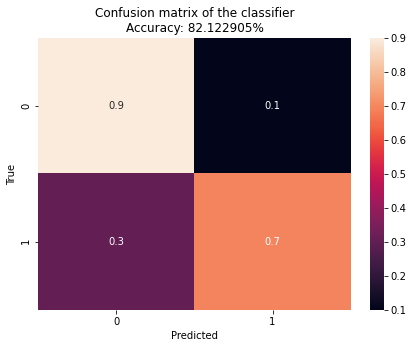

<Figure size 432x288 with 0 Axes>

In [48]:
create_tree(attributes, df, maxdepth=5, matrix=True)
plt.savefig('graphs/optimal.png')